In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
trx = pd.read_csv('../data/trx_short.csv')
merchants = pd.read_csv('../data/merchants.csv')
new_merchant_trx = pd.read_csv('../data/new_merchant_transactions.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
trx.describe()

,Unnamed: 0,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000,454496.000000,500000.000000,500000.000000
mean,1.456785e+07,129.400762,0.650798,480.928144,-4.49417,0.001345,2.192134,10.580886,26.853144
std,8.394785e+06,104.276558,3.057671,249.387204,3.59205,197.865751,1.530514,6.365464,9.689482
min,9.500000e+01,-1.000000,-1.000000,-1.000000,-13.00000,-0.746893,1.000000,-1.000000,-1.000000
25%,7.308035e+06,53.000000,0.000000,307.000000,-7.00000,-0.720025,1.000000,9.000000,19.000000
50%,1.457128e+07,90.000000,0.000000,454.000000,-4.00000,-0.688304,1.000000,9.000000,29.000000
75%,2.182521e+07,212.000000,1.000000,705.000000,-2.00000,-0.602593,3.000000,16.000000,34.000000
max,2.911229e+07,347.000000,999.000000,891.000000,0.00000,92341.383343,5.000000,24.000000,41.000000


In [4]:
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 15 columns):
Unnamed: 0              500000 non-null int64
authorized_flag         500000 non-null object
card_id                 500000 non-null object
city_id                 500000 non-null int64
category_1              500000 non-null object
installments            500000 non-null int64
category_3              496950 non-null object
merchant_category_id    500000 non-null int64
merchant_id             497634 non-null object
month_lag               500000 non-null int64
purchase_amount         500000 non-null float64
purchase_date           500000 non-null object
category_2              454496 non-null float64
state_id                500000 non-null int64
subsector_id            500000 non-null int64
dtypes: float64(2), int64(7), object(6)
memory usage: 57.2+ MB


In [5]:
trx.head()

,Unnamed: 0,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,13637485,Y,C_ID_a597e549b3,223,N,0,A,307,M_ID_0e6ff0e2cb,0,-0.524275,2018-02-09 20:12:07,5.0,21,19
1,25708968,Y,C_ID_bc25a700c7,87,N,0,A,80,M_ID_8f151ed47f,-13,-0.692812,2017-01-27 22:23:52,3.0,11,37
2,8895861,Y,C_ID_ead4ee2e98,277,N,0,A,651,M_ID_b2649626b5,-9,-0.684097,2017-05-10 13:53:35,4.0,13,2
3,16115084,Y,C_ID_20dcc8b199,169,N,0,A,560,M_ID_47a50acdfe,-1,-0.728500,2018-01-02 17:56:46,5.0,20,34
4,12573623,N,C_ID_e558dffcd3,246,N,3,C,117,M_ID_6911f78c16,-7,-0.296112,2017-07-05 08:30:55,3.0,1,2


In [6]:
print('auth flag: {}\n'
      'unique cards: {}\n'
      'cat_1: {}\n'
      'cat_2: {}\n'
      'cat_3: {}\n'
      'unique merch_cat: {}\n'
      'unique merch_id: {}\n'
      'state_id: {}\n'
      'subsector_id: {}\n'
      .format(
          trx.authorized_flag.unique(),
          len(trx.card_id.unique()),
          trx.category_1.unique(),
          trx.category_2.unique(),
          trx.category_3.unique(),
          len(trx.merchant_category_id.unique()),
          len(trx.merchant_id.unique()),
          len(trx.state_id.unique()),
          len(trx.subsector_id.unique())
      ), sep='\n')

auth flag: ['Y' 'N']
unique cards: 195835
cat_1: ['N' 'Y']
cat_2: [ 5.  3.  4.  1. nan  2.]
cat_3: ['A' 'C' 'B' nan]
unique merch_cat: 289
unique merch_id: 109905
state_id: 25
subsector_id: 41



Some data cleaning/recoding first-steps:
- `authorized_flag` to boolean
- `city_id` to str
- define `city_id` (to put on map)
- `category_1` to boolean
- `category_3` meaning for A, B, C?
- units for `purchase_amount`?
- `category_1` may need to exist as str
- `purchase_date` to datetime

In [7]:
trx.purchase_date = pd.to_datetime(trx.purchase_date)
trx.authorized_flag = trx.authorized_flag.apply(lambda x: True if x == 'Y' else False)
trx.city_id = trx.city_id.apply(str)

In [8]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

Not going to worry about merchants for now. Will first focus on making predictions using only customer data.

First we will need to do some feature engineering for our customers

## Customer level feature engineering

In [9]:
groups = trx.groupby('card_id')
last_day = trx.purchase_date.max()
users = pd.DataFrame()
users['tof'] = (last_day - groups.purchase_date.min()).apply(lambda x: x.days)
users['recency'] = (last_day - groups.purchase_date.max()).apply(lambda x: x.days)
users['frequency'] = groups.size()
users['log_freq'] = users.frequency.apply(np.log)
users['amt'] = groups.purchase_amount.sum()
users['log_amt'] = users['amt'].apply(np.log)
users['avg_amt'] = users['amt'] / users['frequency']
users['log_avg_amt'] = users['avg_amt'].apply(np.log)
users['charge_per_day'] = users['frequency'] / (users['tof'] + 1)
users['log_charge_per_day'] = users['charge_per_day'].apply(np.log)
users['max_amt'] = groups.purchase_amount.max()
users['log_max_amt'] =  users['max_amt'].apply(np.log)
users['n_declines'] = groups.size() - groups.authorized_flag.sum()
users['log_n_declines'] = users['n_declines'].apply(lambda x: np.log(x+1))

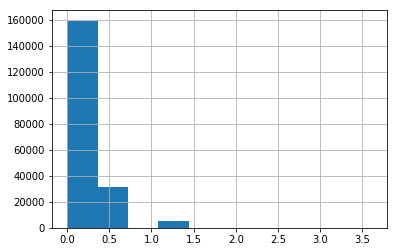

In [10]:
users.log_n_declines.hist()

In [11]:
users.head()

,tof,recency,frequency,log_freq,amt,log_amt,avg_amt,log_avg_amt,charge_per_day,log_charge_per_day,max_amt,log_max_amt,n_declines,log_n_declines
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,359,60,5,1.609438,-1.958360,NaN,-0.391672,NaN,0.013889,-4.276666,0.004418,-5.422116,2.0,1.098612
C_ID_0001238066,69,68,2,0.693147,-1.166193,NaN,-0.583096,NaN,0.028571,-3.555348,-0.446528,NaN,0.0,0.000000
C_ID_0001506ef0,75,75,1,0.000000,-0.536537,NaN,-0.536537,NaN,0.013158,-4.330733,-0.536537,NaN,0.0,0.000000
C_ID_0001793786,222,204,2,0.693147,-0.956783,NaN,-0.478392,NaN,0.008969,-4.714025,-0.382440,NaN,0.0,0.000000
C_ID_000183fdda,144,98,2,0.693147,1.216817,0.196238,0.608408,-0.496909,0.013793,-4.283587,1.905121,0.644546,0.0,0.000000


It actually doesn't make sense to take logs on any features based on `purchase_amount` as it has been standardized and thus contains many negative values

In [12]:
full = train.join(users, how='inner', on='card_id')
full.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,tof,recency,frequency,log_freq,amt,log_amt,avg_amt,log_avg_amt,charge_per_day,log_charge_per_day,max_amt,log_max_amt,n_declines,log_n_declines
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,240,142,3,1.098612,-2.154020,NaN,-0.718007,NaN,0.012448,-4.386185,-0.707689,NaN,0.0,0.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,225,43,5,1.609438,-2.472703,NaN,-0.494541,NaN,0.022124,-3.811097,-0.341192,NaN,0.0,0.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,397,122,2,0.693147,-1.330177,NaN,-0.665088,NaN,0.005025,-5.293305,-0.635712,NaN,0.0,0.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,154,153,2,0.693147,-1.412958,NaN,-0.706479,NaN,0.012903,-4.350278,-0.686336,NaN,0.0,0.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,45,45,1,0.000000,-0.691310,NaN,-0.691310,NaN,0.021739,-3.828641,-0.691310,NaN,0.0,0.0


In [13]:
# Log/standardize predictors
X = full[['feature_1', 'feature_2', 'feature_3', 'tof', 'recency', 'log_freq',
          'amt', 'avg_amt', 'max_amt', 'log_charge_per_day', 'n_declines']]
Y = full['target']

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
len(X_train.dropna())

(90933, 11) (30312, 11) (90933,) (30312,)


90933

In [15]:
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Root Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(Y_test, Y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, Y_pred))



Coefficients: 
 [-3.70553153e-02 -2.53553621e-02  9.19326156e-02 -2.01173671e-04
 -2.66547693e-03 -1.35909613e-01 -3.38852189e-02  1.15348381e-04
  3.38694781e-02 -4.50834968e-02 -2.28308408e-01]
Root Mean squared error: 3.73
Variance score: 0.01
